In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import os
import math
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score
import seaborn as sns
from sklearn import metrics
import tempfile
import mlflow
from mlflow.models import infer_signature
from utils import make_data, make_label, calc_leq, leq_filter, validate, figure, figure_detail, plot_timeseries, fig_pr, auc_gs, fig_th_f

# クロスバリデーション
## 訓練、テストへ分割
* テスト（最終評価用）：6, 7, 8, 9 日目
---
ラベル付け
* 全体：0, 1, 2, 3, 4, 5 日目
* 訓練ローテ：(訓練、ラベル付与対象)=([0, 1, 2, 3, 4], 5)・・・([5, 0, 1, 2, 3], 4)

2024/01/05 18:03:26 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/01/05 18:03:26 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



訓練データ：[1, 2, 3, 4, 5]
ラベル付与データ：[0]日目


2024/01/05 18:03:33 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.


------------------------------------------------------


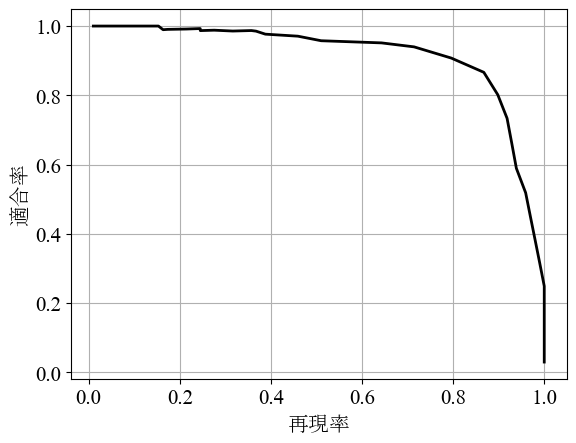

AUC：0.9081415649157594
理想の閾値：0.19999999999999998
F値（最高）：0.866881709369053
適合率（F値が最高の時）：0.8664169787765293
再現率（F値が最高の時）：0.8673469387755102
訓練データ：[0, 2, 3, 4, 5]
ラベル付与データ：[1]日目


2024/01/05 18:06:25 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.


------------------------------------------------------


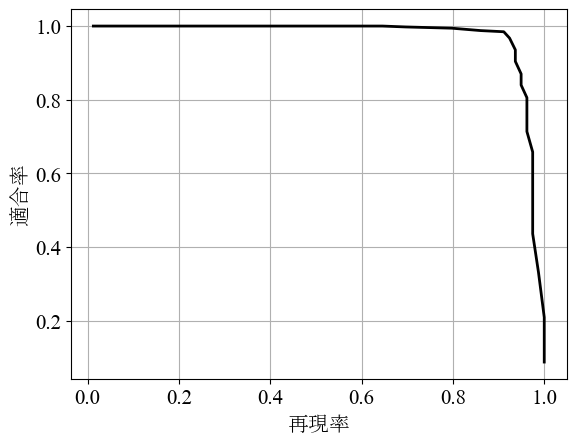

AUC：0.9599758290465359
理想の閾値：0.24615384615384614
F値（最高）：0.94654410434453
適合率（F値が最高の時）：0.984516129032258
再現率（F値が最高の時）：0.9113924050632911
訓練データ：[0, 1, 3, 4, 5]
ラベル付与データ：[2]日目


2024/01/05 18:08:22 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.


------------------------------------------------------


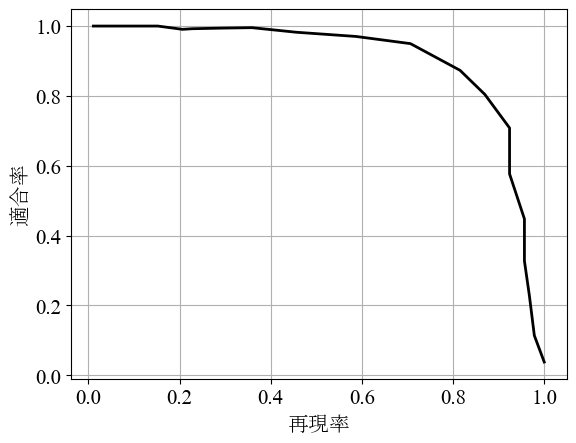

AUC：0.8944368250837484
理想の閾値：0.12307692307692307
F値（最高）：0.8432479585160775
適合率（F値が最高の時）：0.8732747804265998
再現率（F値が最高の時）：0.8152173913043478
訓練データ：[0, 1, 2, 4, 5]
ラベル付与データ：[3]日目


2024/01/05 18:11:15 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.


------------------------------------------------------


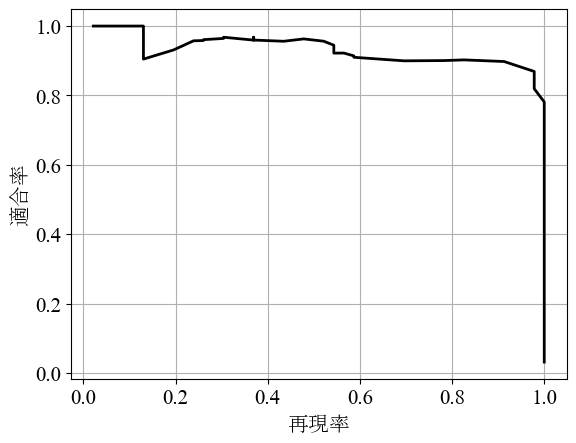

AUC：0.910797709912488
理想の閾値：0.2769230769230769
F値（最高）：0.9204354967066832
適合率（F値が最高の時）：0.8690647482014389
再現率（F値が最高の時）：0.9782608695652174
訓練データ：[0, 1, 2, 3, 5]
ラベル付与データ：[4]日目


2024/01/05 18:13:46 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.


------------------------------------------------------


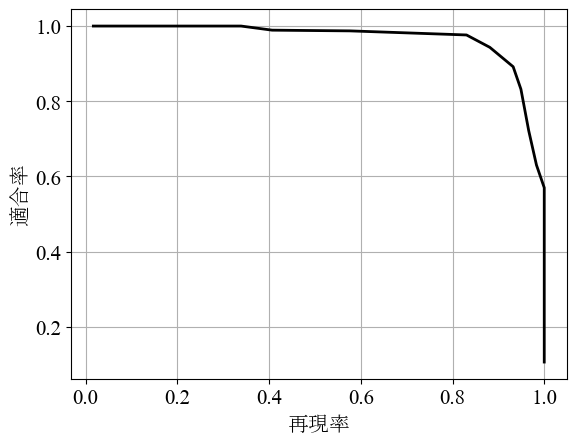

AUC：0.9513958396207982
理想の閾値：0.10769230769230768
F値（最高）：0.9115771784437452
適合率（F値が最高の時）：0.8918439716312057
再現率（F値が最高の時）：0.9322033898305084
訓練データ：[0, 1, 2, 3, 4]
ラベル付与データ：[5]日目


2024/01/05 18:16:37 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.


------------------------------------------------------


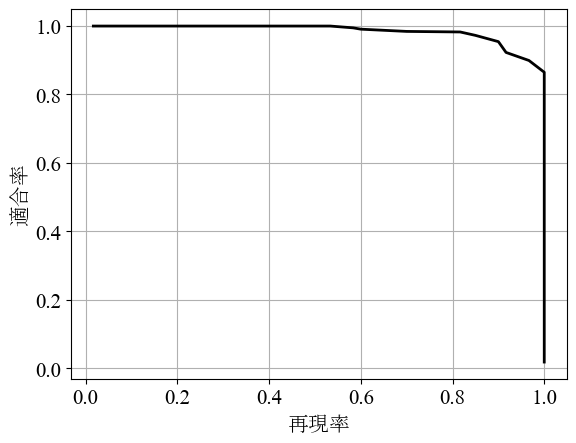

AUC：0.9679576806735108
理想の閾値：0.23076923076923075
F値（最高）：0.9317827598609281
適合率（F値が最高の時）：0.8993288590604027
再現率（F値が最高の時）：0.9666666666666667
=============CV_AUC_mean===============
0.9321175748754734


In [2]:
# remote_server_uri = "http://localhost:5000"  # set to your server URI
# mlflow.set_tracking_uri(remote_server_uri)

mlflow.autolog(log_models=False)

# 実験をアクティブ化(設定)する。ない場合は新たな実験を作成してアクティブ化する
mlflow.set_experiment("CV")
with mlflow.start_run():
    test_day=[6, 7, 8, 9]
    semi_train_day=[0, 1, 2, 3, 4, 5]
    mlflow.log_params({'CV_day':semi_train_day})
    auc_list=[]
    for day in semi_train_day:
        data_dir='filtered_csv_label'
        original = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
        df = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
        df=df[df['day']<=9]

        test_df=df[(df['day'].isin(test_day))].reset_index(drop=True)
        semi_train_df=df[(df['day'].isin(semi_train_day))].reset_index(drop=True)

        best_params={'window': 5, 'nk': 12}
        df_list=[]
        window=best_params['window']
        for i in set(df['day']):
            lag=[] 
            lag.append(make_data(semi_train_df.loc[semi_train_df['day']==i, ['original']], 'original', window))
            lag.append(semi_train_df.loc[semi_train_df['day']==i, ['day']])
            lag.append(semi_train_df.loc[semi_train_df['day']==i, ['label']])
            df_add_lag=pd.concat(lag, axis=1)
            df_list.append(df_add_lag)
        semi_train_df=pd.concat(df_list)
        semi_train_df=semi_train_df.dropna().reset_index(drop=True)
        semi_train_df.loc[:, 'knnd']=0
        semi_train_df.loc[:, 'knn_label']=0
        
        # テストデータとする日
        i=[day]
        label_train_day=[k for k in semi_train_day if k not in i]
        label_grant_day=i
        print(f'訓練データ：{label_train_day}')
        print(f'ラベル付与データ：{label_grant_day}日目')
        semi_train_x=semi_train_df[(semi_train_df['day'].isin(label_train_day))][semi_train_df.columns[:-4]].reset_index(drop=True)
        labeling_x=semi_train_df[(semi_train_df['day'].isin(label_grant_day))][semi_train_df.columns[:-4]].reset_index(drop=True)
        
        nk=best_params['nk']
        neigh = NearestNeighbors(n_neighbors=nk)
        neigh.fit(semi_train_x)
        d = neigh.kneighbors(labeling_x)[0]
        d = np.mean(d, axis=1)

        semi_train_df.loc[semi_train_df['day'].isin(label_grant_day), 'knnd']=d
        print('------------------------------------------------------')

        test_v=semi_train_df.loc[semi_train_df['day'].isin(label_grant_day), ['original', 'label']].copy().reset_index(drop=True)
        d_test=(d-d.min())/(d.max()-d.min())

        thr_bins=50
        p_score, r_score, f_score, thresholds, thr, auc = fig_pr(test_v, d_test, thr_bins)
        f_max=f_score.max()
        p_max=p_score[np.argmax(f_score)]
        r_max=r_score[np.argmax(f_score)]
        print('\033[31m'+f'AUC：{auc}'+'\033[0m')
        print(f'理想の閾値：{thr}')
        print(f'F値（最高）：{f_max}')
        print(f'適合率（F値が最高の時）：{p_max}')
        print(f'再現率（F値が最高の時）：{r_max}')
        auc_list.append(auc)
        
    #平均
    auc_mean=np.mean(auc_list)
    # Log the loss metric
    mlflow.log_metric("CV_test_AUC", auc_mean)
    print('=============CV_AUC_mean===============')
    print(auc_mean)

## 訓練データとテストデータの重複を確認

In [3]:
semi_train_x.drop_duplicates()

,original,original_lag1,original_lag2,original_lag3,original_lag4
0,53.6,53.2,52.8,52.8,53.4
1,54.0,53.6,53.2,52.8,52.8
2,54.7,54.0,53.6,53.2,52.8
3,55.7,54.7,54.0,53.6,53.2
4,55.5,55.7,54.7,54.0,53.6
...,...,...,...,...,...
1961397,45.8,45.8,46.1,46.2,45.6
1961398,45.0,45.8,45.8,46.1,46.2
1961399,45.2,45.0,45.8,45.8,46.1
1961400,45.1,45.2,45.0,45.8,45.8


In [4]:
labeling_x.drop_duplicates()

,original,original_lag1,original_lag2,original_lag3,original_lag4
0,47.9,47.8,47.4,47.2,46.9
1,47.8,47.9,47.8,47.4,47.2
2,48.4,47.8,47.9,47.8,47.4
3,49.0,48.4,47.8,47.9,47.8
4,49.7,49.0,48.4,47.8,47.9
...,...,...,...,...,...
431973,44.8,45.4,45.6,45.0,45.7
431974,45.1,44.8,45.4,45.6,45.0
431975,45.4,45.1,44.8,45.4,45.6
431976,45.0,45.4,45.1,44.8,45.4


In [5]:
duplicates = pd.merge(semi_train_x.drop_duplicates(), labeling_x.drop_duplicates(), how='inner')
duplicates

,original,original_lag1,original_lag2,original_lag3,original_lag4
0,50.0,50.6,50.7,50.9,51.4
1,49.7,50.0,50.6,50.7,50.9
2,50.1,50.0,49.9,49.2,48.7
3,47.9,47.6,47.5,47.6,47.7
4,46.8,46.9,46.4,46.7,46.3
...,...,...,...,...,...
95970,45.0,45.5,45.5,45.4,45.4
95971,44.8,45.0,45.5,45.5,45.4
95972,45.1,44.7,45.0,45.0,45.3
95973,45.2,45.1,44.7,45.0,45.0


In [9]:
auc_list

[0.9081415649157594,
 0.9599758290465359,
 0.8944368250837484,
 0.910797709912488,
 0.9513958396207982,
 0.9679576806735108]

In [6]:
! mlflow gc --backend-store-uri ./mlruns

In [1]:
! mlflow ui --port 5001 

^C
